<a href="https://colab.research.google.com/github/Poojitha731/FMML_M1L1.ipynb/blob/main/Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [3]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-02-09 15:55:16--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  2.77MB/s    in 0.3s    

2025-02-09 15:55:17 (2.77 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [4]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [5]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [8]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [9]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


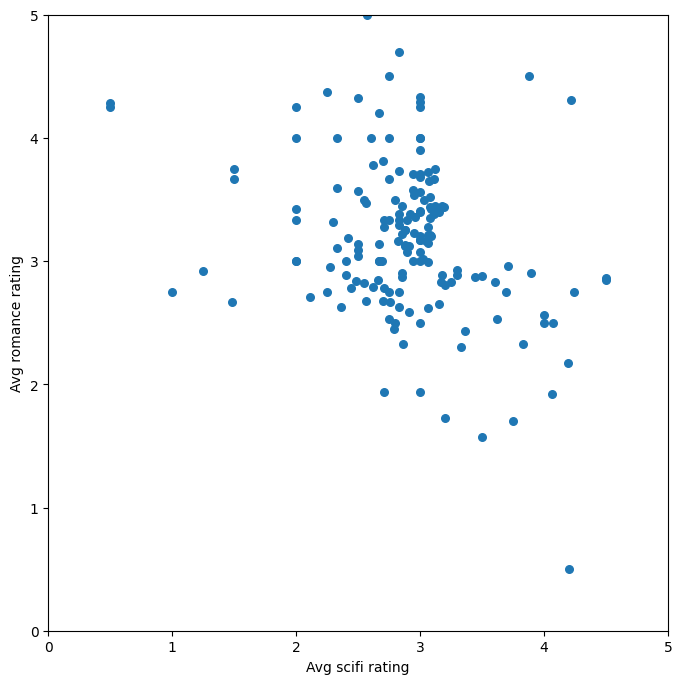

In [10]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

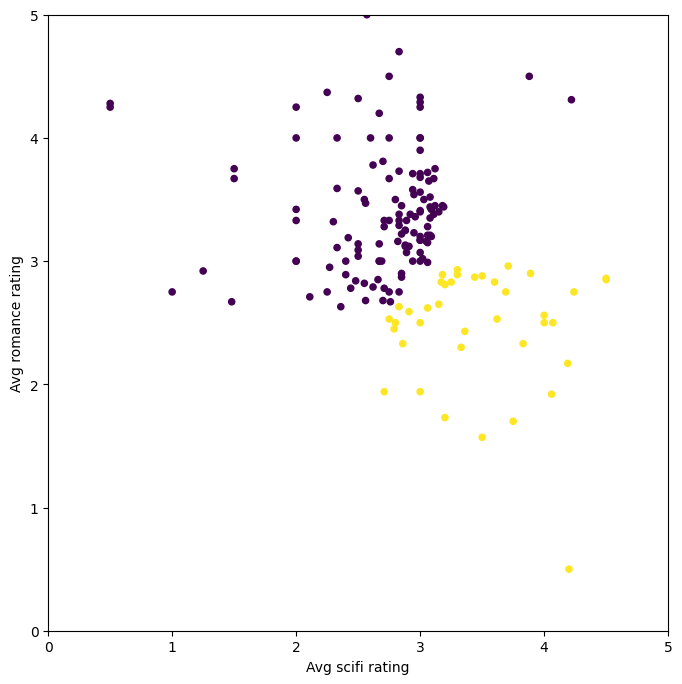

In [11]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

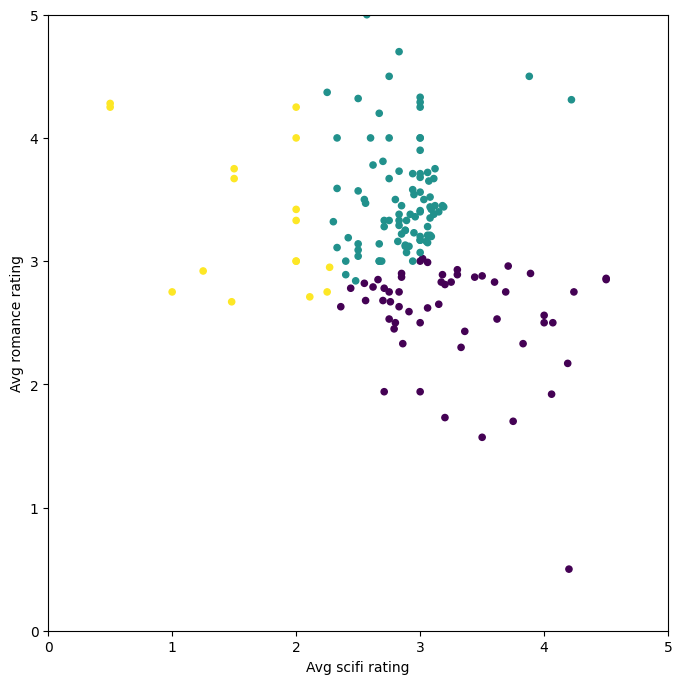

In [12]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



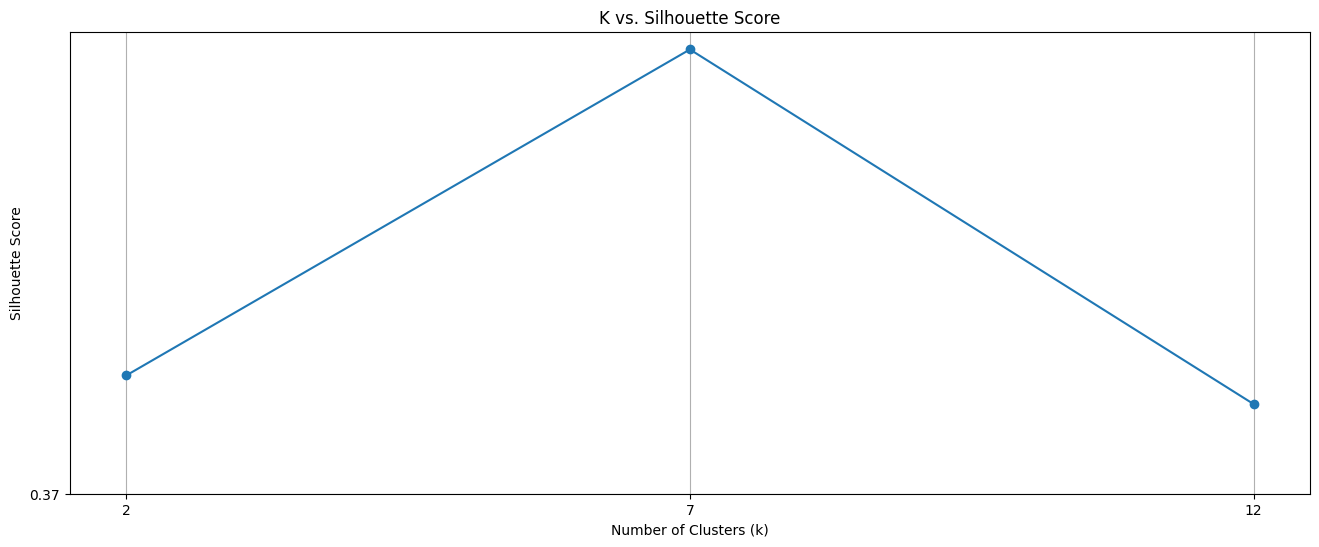

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating', 'avg_romance_rating']]

# Choose the range of k values to test (avoid k > number of samples)
possible_k_values = range(2, min(len(df), 15), 5)  # Capping at 15 for efficiency

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(data)
    predictions = kmeans.labels_  # Using labels instead of predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate silhouette scores for all k values we're interested in
errors_per_k = [clustering_errors(k, df) for k in possible_k_values]

# Plot the silhouette score for each k value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k, marker='o', linestyle='-')

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values) + 1, 5.0)
ax.set_xticks(xticks)
ax.xaxis.grid(True, which='both')

yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), 0.05)
ax.set_yticks(yticks)
ax.yaxis.grid(True, which='both')

# Labels
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("K vs. Silhouette Score")

plt.show()

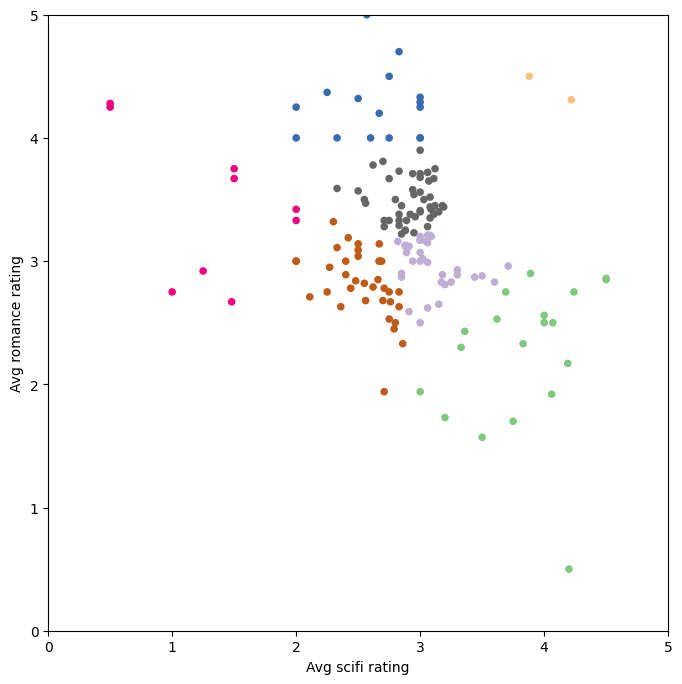

In [16]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [15]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


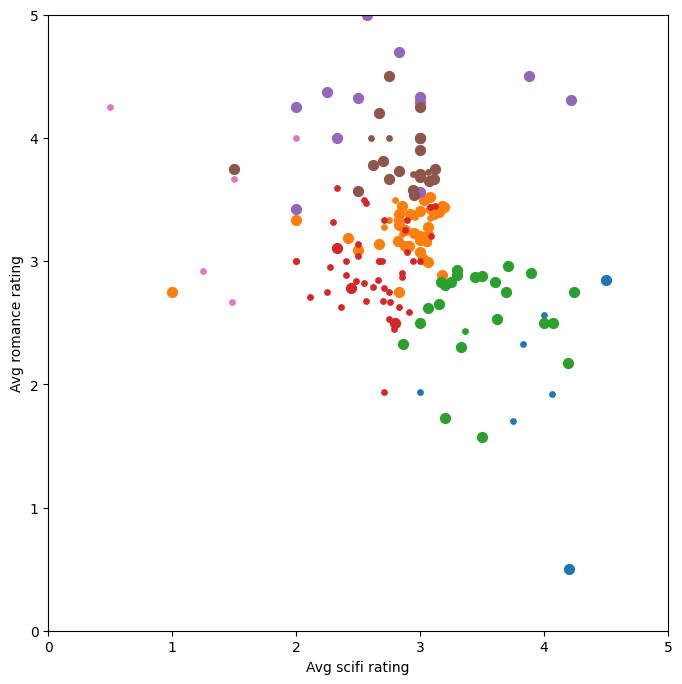

In [17]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

In [18]:
# CODE

### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [19]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


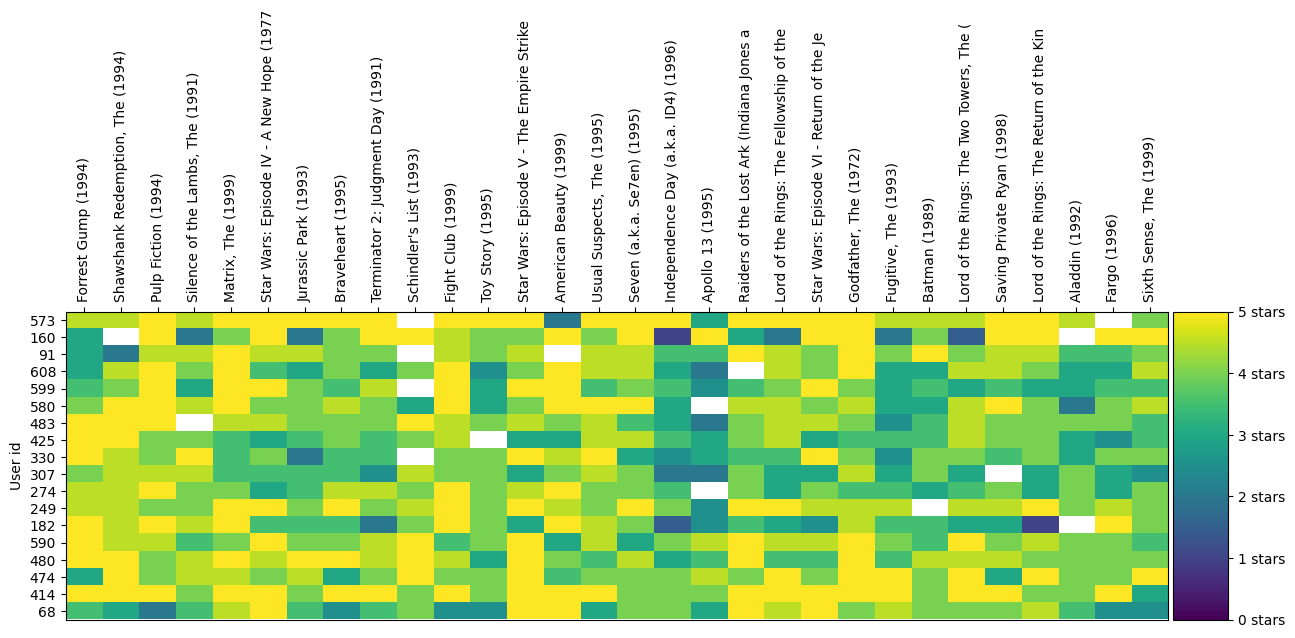

In [22]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [21]:
import pandas as pd

# Define function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # Count the number of ratings for each movie
    movie_counts = user_movie_ratings.count()

    # Sort movies by number of ratings in descending order
    most_rated_movies = user_movie_ratings.loc[:, movie_counts.nlargest(max_number_of_movies).index]

    return most_rated_movies

# Define function to get users who rate the most movies
def get_users_who_rate_the_most(most_rated_movies, n_users):
    # Count the number of ratings per user (fewer NaN values means more ratings)
    most_rated_movies = most_rated_movies.copy()  # Prevent modifying original DataFrame
    most_rated_movies["num_ratings"] = most_rated_movies.notnull().sum(axis=1)

    # Select top n_users who have rated the most movies
    most_rated_movies = most_rated_movies.nlargest(n_users, "num_ratings")

    # Drop the helper column
    most_rated_movies = most_rated_movies.drop(columns=["num_ratings"])

    return most_rated_movies

# Define function to sort by rating density
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# Choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print dataset dimensions and first few rows
print("Dataset dimensions:", most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())

Dataset dimensions: (18, 30)
title   Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
userId                                                          
68                      3.5                               3.0   
414                     5.0                               5.0   
474                     3.0                               5.0   
480                     5.0                               5.0   
590                     5.0                               4.5   

title   Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
userId                                                          
68                      2.0                               3.5   
414                     5.0                               4.0   
474                     4.0                               4.5   
480                     4.0                               4.5   
590                     4.5                               3.5   

title   Matrix, The (1999)  Star Wars: Episode IV - A New H

In [23]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

In [24]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

### Predictions and Recommendation

In [26]:
import pandas as pd
from sklearn.cluster import KMeans

# 20 clusters with KMeans (removing deprecated 'algorithm' parameter)
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
predictions = kmeans.fit_predict(sparse_ratings)

# Select the most rated movies and reset the index
most_rated_movies = get_most_rated_movies(user_movie_ratings, 1000).reset_index()

# Ensure the number of rows match before concatenation
if len(most_rated_movies) == len(predictions):
    clustered = pd.concat([most_rated_movies, pd.DataFrame({'group': predictions})], axis=1)
else:
    raise ValueError("Mismatch in row count between most_rated_movies and predictions")

# Call the function to visualize clusters (assuming it's defined elsewhere)
# draw_movie_clusters(clustered, max_users, max_movies)

# Print a sample of clustered data
print(clustered.head())

   userId  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
0       1                  4.0                               NaN   
1       2                  NaN                               3.0   
2       3                  NaN                               NaN   
3       4                  NaN                               NaN   
4       5                  NaN                               3.0   

   Pulp Fiction (1994)  Silence of the Lambs, The (1991)  Matrix, The (1999)  \
0                  3.0                               4.0                 5.0   
1                  NaN                               NaN                 NaN   
2                  NaN                               NaN                 NaN   
3                  1.0                               5.0                 1.0   
4                  5.0                               NaN                 NaN   

   Star Wars: Episode IV - A New Hope (1977)  Jurassic Park (1993)  \
0                                       

In [34]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

3.9545454545454546

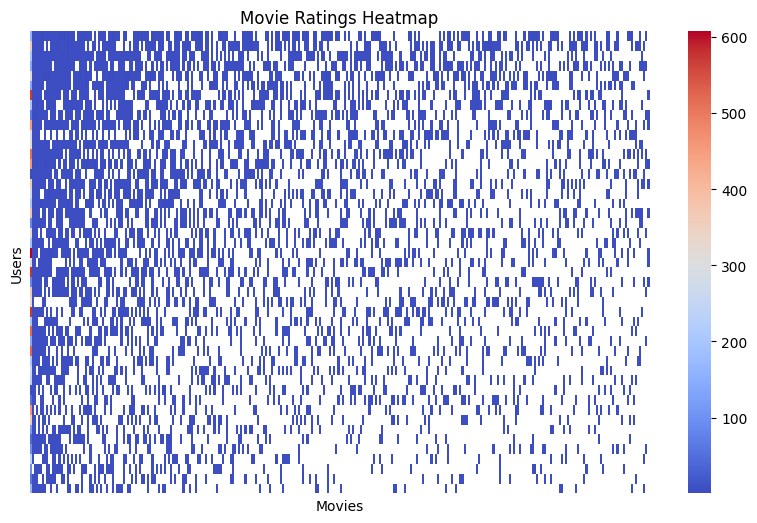

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define sorting function (if not already defined)
def sort_by_rating_density(df, n_movies, n_users):
    """Sorts movies and users by rating density."""
    df = df.loc[:, df.count().sort_values(ascending=False).index[:n_movies]]  # Top movies by rating count
    df = df.loc[df.count(axis=1).sort_values(ascending=False).index[:n_users], :]  # Top users by rating count
    return df

# Define function to draw heatmap
def draw_movies_heatmap(cluster, axis_labels=True):
    """Draws a heatmap for the given cluster."""
    plt.figure(figsize=(10, 6))
    sns.heatmap(cluster, cmap='coolwarm', cbar=True, xticklabels=axis_labels, yticklabels=axis_labels)
    plt.xlabel("Movies")
    plt.ylabel("Users")
    plt.title("Movie Ratings Heatmap")
    plt.show()

# Assuming clustered DataFrame is already created
cluster_number = 11
n_users = 75
n_movies = 300

# Check if 'group' exists in clustered DataFrame
if 'group' in clustered.columns:
    cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1, errors='ignore')

    # Sort and print the cluster
    cluster = sort_by_rating_density(cluster, n_movies, n_users)
    draw_movies_heatmap(cluster, axis_labels=False)
else:
    print("Error: 'group' column not found in clustered DataFrame.")

In [29]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

,0
userId,268.106383
Star Wars: Episode V - The Empire Strikes Back (1980),4.326087
Star Wars: Episode IV - A New Hope (1977),4.420455
Star Wars: Episode VI - Return of the Jedi (1983),4.038462
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),4.423077
Alien (1979),3.972222
"Silence of the Lambs, The (1991)",4.430556
Back to the Future (1985),4.132353
Saving Private Ryan (1998),4.333333
E.T. the Extra-Terrestrial (1982),3.803030


In [30]:
cluster

,userId,Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode VI - Return of the Jedi (1983),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Alien (1979),"Silence of the Lambs, The (1991)",Back to the Future (1985),Saving Private Ryan (1998),E.T. the Extra-Terrestrial (1982),...,"Jungle Book, The (1967)",Last Action Hero (1993),Wayne's World (1992),"Three Musketeers, The (1993)",Casino (1995),"Sound of Music, The (1965)",Mr. Holland's Opus (1995),Desperado (1995),"Lord of the Rings: The Two Towers, The (2002)",What's Eating Gilbert Grape (1993)
159,160,4.0,5.0,5.0,3.0,2.0,2.0,5.0,5.0,3.0,...,4.0,0.5,NaN,NaN,NaN,2.0,NaN,NaN,1.5,NaN
367,368,3.0,4.0,4.0,4.0,4.0,4.0,NaN,5.0,NaN,...,NaN,2.0,NaN,2.0,4.0,3.0,NaN,3.0,NaN,NaN
201,202,5.0,4.0,3.0,5.0,4.0,5.0,4.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
139,140,3.0,4.0,3.5,4.0,4.0,4.0,3.0,5.0,4.0,...,4.0,NaN,NaN,NaN,NaN,5.0,4.5,3.0,4.0,NaN
312,313,4.0,3.0,3.0,5.0,4.0,5.0,2.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
134,135,4.0,4.0,4.0,4.0,4.0,5.0,NaN,4.0,4.0,...,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569,570,4.0,3.5,4.0,4.0,3.5,NaN,4.0,4.0,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
198,199,3.5,4.0,2.0,4.0,4.0,4.0,NaN,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
65,66,4.0,2.5,3.0,3.0,4.0,4.0,3.0,4.5,NaN,...,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0
451,452,5.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,5.0,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,5.0


## Using Collaborative Filtering (With fast.ai)

In [33]:
import pandas as pd

# Assume `cluster` is a DataFrame with user IDs as index and movie ratings as columns
user_id = 7

# Check if the user exists in the DataFrame
if user_id in cluster.index:
    # Get all this user's ratings
    user_ratings = cluster.loc[user_id, :]

    # Identify movies not rated by the user
    unrated_movies = user_ratings[user_ratings.isna()].index  # Get indices of NaN values

    # Get average ratings for all movies
    avg_ratings = cluster.mean()  # Compute mean rating for each movie

    # Extract only the movies the user has not rated
    unrated_avg_ratings = avg_ratings.loc[unrated_movies]  # Filter using index

    # Sort movies by their average ratings in descending order
    recommended_movies = unrated_avg_ratings.sort_values(ascending=False)

    # Display top 20 recommendations
    print(recommended_movies.head(20))
else:
    print(f"User ID {user_id} not found in the dataset.")

User ID 7 not found in the dataset.


In [35]:
!pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.2 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 455, in run
    installed = install_given_reqs(
                ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-pac

In [1]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [36]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [37]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [38]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [39]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [40]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [41]:
dls.show_batch()

,user,title,rating
0,504,Jurassic Park (1993),4
1,495,Cape Fear (1991),4
2,130,Tales From the Crypt Presents: Demon Knight (1995),4
3,279,Billy Madison (1995),2
4,367,"Silence of the Lambs, The (1991)",5
5,246,Philadelphia (1993),4
6,593,"Princess Bride, The (1987)",5
7,902,Men in Black (1997),3
8,627,E.T. the Extra-Terrestrial (1982),3
9,830,Unforgettable (1996),4


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [42]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [43]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.891770,0.933825,00:08
1,0.665371,0.884098,00:06
2,0.531098,0.862088,00:07
3,0.481728,0.846966,00:06
4,0.440150,0.843087,00:07


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [44]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [45]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [46]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [47]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3506),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3204), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.3103), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2831), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2767), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2640), 'Kansas City (1996)', 2.260869565217391),
 (tensor(-0.2627),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2508), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2383), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2375), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2365), 'Jingle All the Way (1996)', 2.111111111111111),
 (tensor(-0.2295), 'Under Siege 2: Dark Territory (1995)', 2.4583333333333335),
 (tensor(-0.2271), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2135), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2092), '

Or the ones with the best bias:

In [48]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5452), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5344), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5205), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5101), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5083), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.5039), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.4990), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4976), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4966), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4646), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4628), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4464), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4421), 'North by Northwest (1959)', 4.284916201117318),
 (tensor(0.4335), 'Raiders of the Lost Ark (1981)', 4.252380952380952),
 (tensor(0.4330), 'Grand Day Out, A (1992)', 4.106060606060606)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [49]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [50]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [51]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0725), 'Three Colors: Blue (1993)'),
 (tensor(1.0495), 'Godfather, The (1972)'),
 (tensor(1.0302), 'Chinatown (1974)'),
 (tensor(1.0275), '12 Angry Men (1957)'),
 (tensor(1.0166), 'Close Shave, A (1995)'),
 (tensor(0.9832), 'Casablanca (1942)'),
 (tensor(0.9734), 'Fargo (1996)'),
 (tensor(0.9729), 'Manchurian Candidate, The (1962)'),
 (tensor(0.9706), 'Apocalypse Now (1979)'),
 (tensor(0.9448), 'Some Folks Call It a Sling Blade (1993)')]

And the worst:

In [53]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.4421), 'Home Alone 3 (1997)'),
 (tensor(-1.2107), 'Jungle2Jungle (1997)'),
 (tensor(-1.1155), "McHale's Navy (1997)"),
 (tensor(-1.1028), 'Operation Dumbo Drop (1995)'),
 (tensor(-1.0905), 'Stupids, The (1996)'),
 (tensor(-1.0776), 'Crow: City of Angels, The (1996)'),
 (tensor(-1.0206), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-0.9922), 'Bio-Dome (1996)'),
 (tensor(-0.9741), 'Striptease (1996)'),
 (tensor(-0.9705), 'Spice World (1997)')]

Same thing for our second dimension:

In [54]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [55]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9202), 'Spice World (1997)'),
 (tensor(0.8711), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8472), 'Jingle All the Way (1996)'),
 (tensor(0.8126), 'Jude (1996)'),
 (tensor(0.8003), 'Brazil (1985)'),
 (tensor(0.7748), 'To Die For (1995)'),
 (tensor(0.7658), 'Lost Highway (1997)'),
 (tensor(0.7219), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7164), 'Keys to Tulsa (1997)'),
 (tensor(0.6984), 'Cable Guy, The (1996)')]

In [56]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1003), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.0900), 'Titanic (1997)'),
 (tensor(-1.0189), 'Forrest Gump (1994)'),
 (tensor(-1.0176), 'Braveheart (1995)'),
 (tensor(-0.9429), "Schindler's List (1993)"),
 (tensor(-0.9064), 'Firm, The (1993)'),
 (tensor(-0.8679), 'Hunt for Red October, The (1990)'),
 (tensor(-0.8311), 'Dave (1993)'),
 (tensor(-0.8300), 'Ghost (1990)'),
 (tensor(-0.8152), 'Indiana Jones and the Last Crusade (1989)')]

And we can even plot the movies according to their scores on those dimensions:

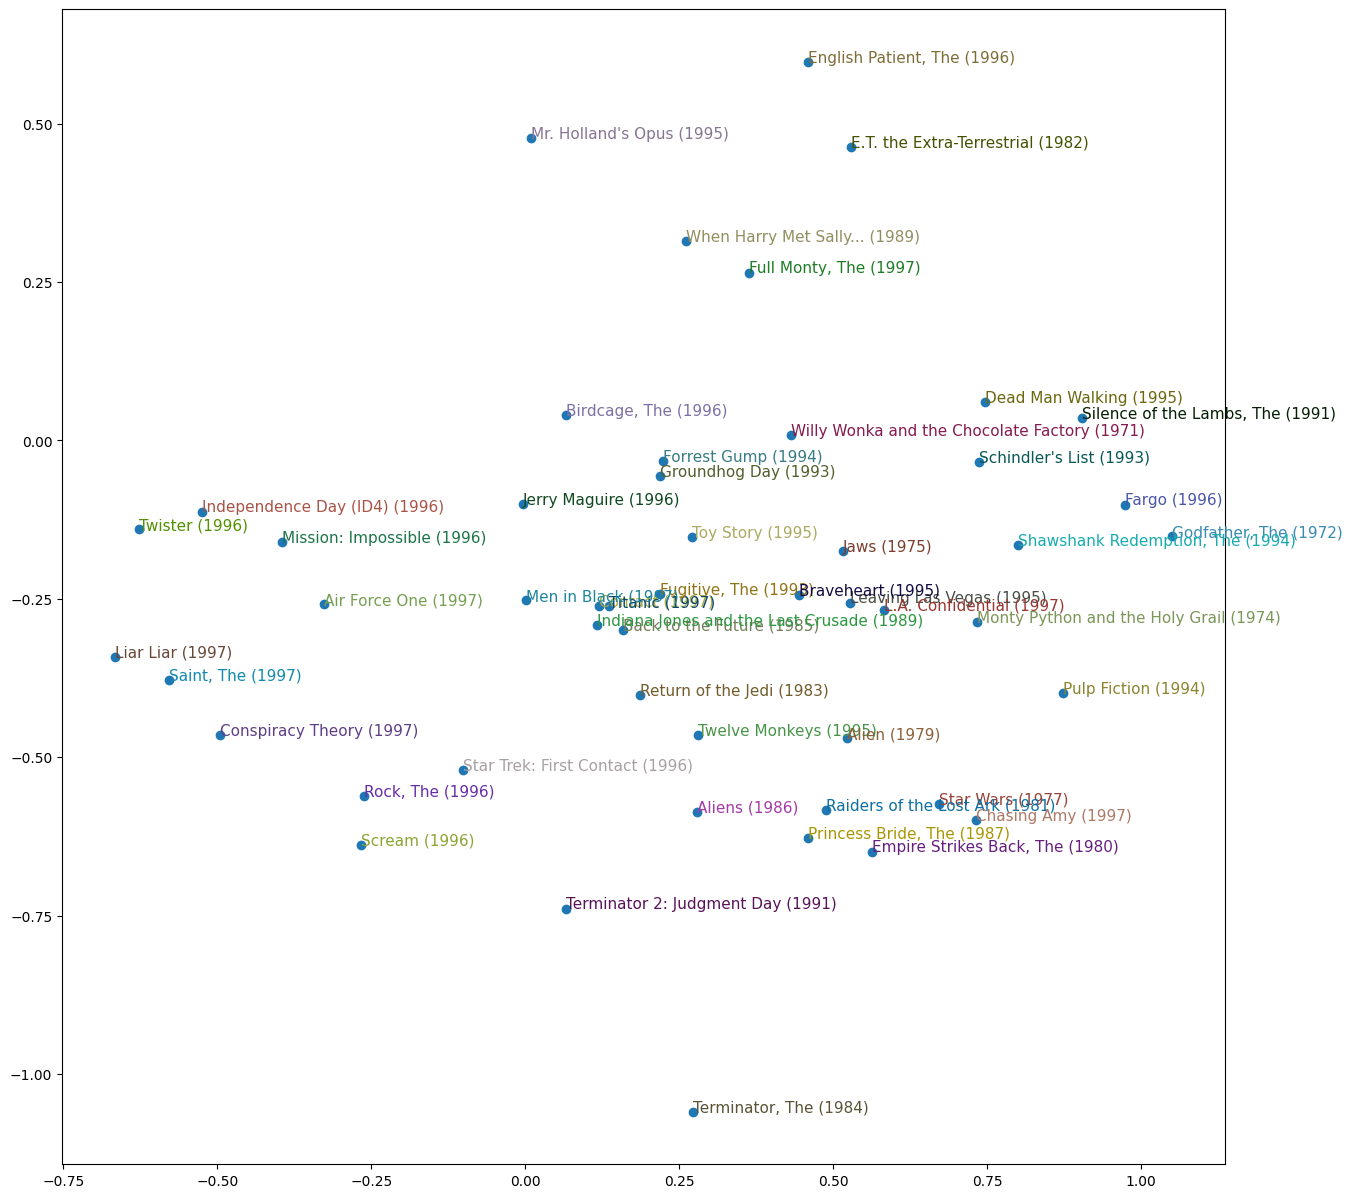

In [57]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [58]:
# CODE